In [1]:
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import subprocess
import h5py
from sklearn.manifold import TSNE
import seaborn as sns
from augment.gan_eval import compute_fid, compute_prdc
sns.set(color_codes=True)
sns.set_style("whitegrid")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

print('torch version', torch.__version__)
print('gitcommit', subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode('ascii').strip())

torch version 1.7.1
gitcommit 19ff3ee


# Feature Visualization and Quality Evaluation

Evaluate the quality of generated node, edge and global features to obtain the results in Table 3 of the paper.

To run this code, first download real and fake (GAN) features from [here]() or extract them using our code.


 NODES
test real /scratch/ssd/data/tmp2/features/nodes_real_test.hdf5
real (2735, 784) 2735
test fake /scratch/ssd/data/tmp2/features/nodes_fake_test.hdf5
fake (2735, 784) 2735


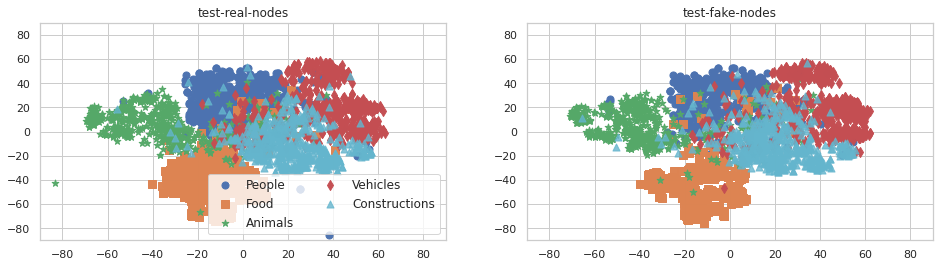

test_zs real /scratch/ssd/data/tmp2/features/nodes_real_test_zs.hdf5
real (2735, 784) 2735
test_zs fake /scratch/ssd/data/tmp2/features/nodes_fake_test_zs.hdf5
fake (2735, 784) 2735


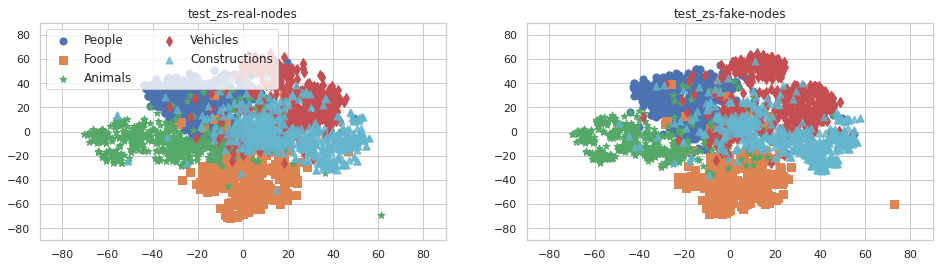

compute feature quality metrics: ['precision', 'density', 'recall', 'coverage']
test real /scratch/ssd/data/tmp2/features/nodes_real_test.hdf5
test real (52477, 3136) 0.0 37.44
test fake /scratch/ssd/data/tmp2/features/nodes_fake_test.hdf5
test fake (52477, 3136) 0.0 35.44
test_zs real /scratch/ssd/data/tmp2/features/nodes_real_test_zs.hdf5
test_zs real (57704, 3136) 0.0 39.72
test_zs fake /scratch/ssd/data/tmp2/features/nodes_fake_test_zs.hdf5
test_zs fake (57704, 3136) 0.0 48.7
computing the metrics...
Real test: ['precision=0.74', 'density=1.02', 'recall=0.74', 'coverage=0.97']; AVG = 0.87
Real test-zs: ['precision=0.67', 'density=0.97', 'recall=0.69', 'coverage=0.94']; AVG = 0.82
GAN: Fake test: ['precision=0.55', 'density=0.70', 'recall=0.42', 'coverage=0.81']; AVG = 0.62
GAN: Fake test-zs: ['precision=0.45', 'density=0.51', 'recall=0.46', 'coverage=0.72']; AVG = 0.53
done for NODES

 EDGES
test real /scratch/ssd/data/tmp2/features/edges_real_test.hdf5
real (1932, 3136) 1932
test 

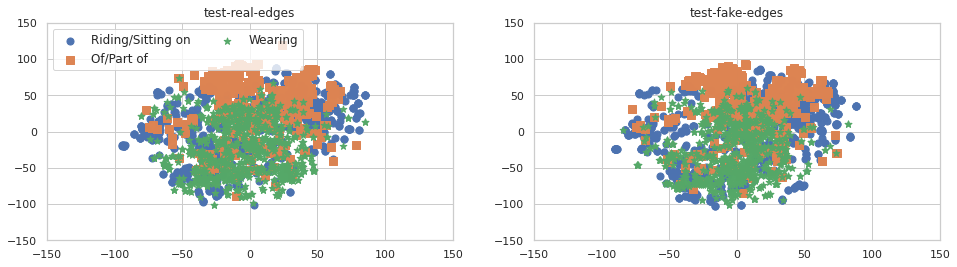

test_zs real /scratch/ssd/data/tmp2/features/edges_real_test_zs.hdf5
real (812, 3136) 812
test_zs fake /scratch/ssd/data/tmp2/features/edges_fake_test_zs.hdf5
fake (812, 3136) 812


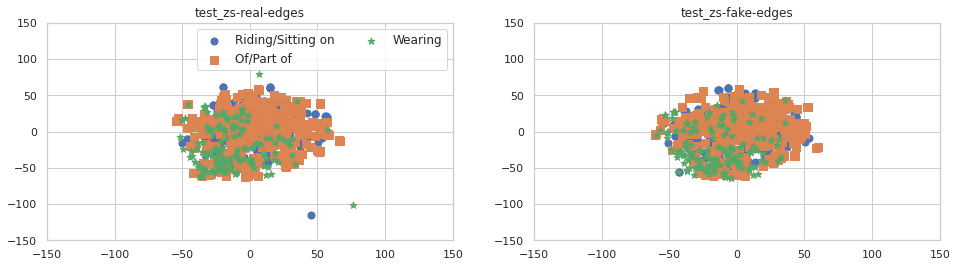

compute feature quality metrics: ['precision', 'density', 'recall', 'coverage']
test real /scratch/ssd/data/tmp2/features/edges_real_test.hdf5
test real (14066, 3136) 0.0 34.7
test fake /scratch/ssd/data/tmp2/features/edges_fake_test.hdf5
test fake (14066, 3136) 0.0 34.3
test_zs real /scratch/ssd/data/tmp2/features/edges_real_test_zs.hdf5
test_zs real (8464, 3136) 0.0 32.38
test_zs fake /scratch/ssd/data/tmp2/features/edges_fake_test_zs.hdf5
test_zs fake (8464, 3136) 0.0 34.38
computing the metrics...
Real test: ['precision=0.74', 'density=1.05', 'recall=0.72', 'coverage=0.97']; AVG = 0.87
Real test-zs: ['precision=0.52', 'density=1.20', 'recall=0.61', 'coverage=0.87']; AVG = 0.80
GAN: Fake test: ['precision=0.54', 'density=0.74', 'recall=0.50', 'coverage=0.79']; AVG = 0.64
GAN: Fake test-zs: ['precision=0.38', 'density=0.40', 'recall=0.50', 'coverage=0.62']; AVG = 0.47
done for EDGES

 FMAPS
test real /scratch/ssd/data/tmp2/features/fmaps_real_test.hdf5
real (1000, 5476) 1000
test fak

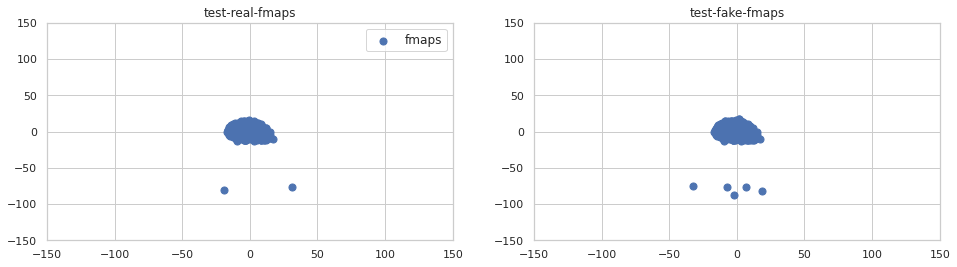

test_zs real /scratch/ssd/data/tmp2/features/fmaps_real_test_zs.hdf5
real (1000, 5476) 1000
test_zs fake /scratch/ssd/data/tmp2/features/fmaps_fake_test_zs.hdf5
fake (1000, 5476) 1000


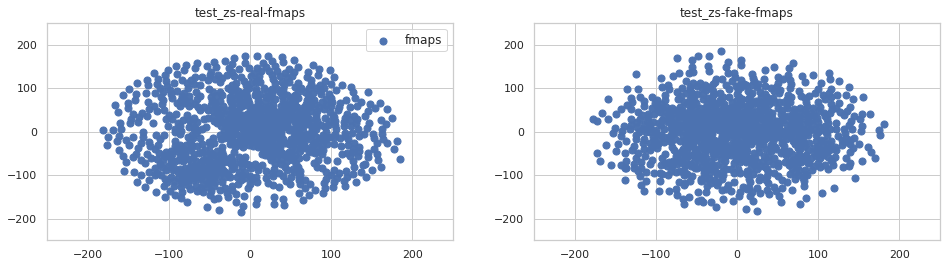

compute feature quality metrics: ['precision', 'density', 'recall', 'coverage']
test real /scratch/ssd/data/tmp2/features/fmaps_real_test.hdf5
test real (1000, 21904) 0.0 38.9
test fake /scratch/ssd/data/tmp2/features/fmaps_fake_test.hdf5
test fake (1000, 21904) 0.0 29.53
test_zs real /scratch/ssd/data/tmp2/features/fmaps_real_test_zs.hdf5
test_zs real (1000, 21904) 0.0 33.47
test_zs fake /scratch/ssd/data/tmp2/features/fmaps_fake_test_zs.hdf5
test_zs fake (1000, 21904) 0.0 32.84
computing the metrics...
Real test: ['precision=0.16', 'density=0.35', 'recall=0.23', 'coverage=0.82']; AVG = 0.39
Real test-zs: ['precision=0.13', 'density=0.29', 'recall=0.24', 'coverage=0.77']; AVG = 0.36
GAN: Fake test: ['precision=0.15', 'density=0.14', 'recall=0.33', 'coverage=0.48']; AVG = 0.27
GAN: Fake test-zs: ['precision=0.03', 'density=0.03', 'recall=0.29', 'coverage=0.15']; AVG = 0.12
done for FMAPS
done!


In [2]:
DATA_PATH_FEAT = './features/'  # where all node, edge, fmap features are stored

markers = ['o', 's', '*', 'd', '^']
cmap = cm.get_cmap('jet')


zs_split = 'test_zs'

stride = 32
seed = 3
rnd = np.random.RandomState(seed)

for case in ['nodes', 'edges', 'fmaps']:
    
    print('\n', case.upper())
    
    if case == 'nodes':
        classes = { 'People': ['man', 'men', 'person', 'woman', 'people', 'boy', 'girl', 'child', 'kid', 'guy', 'lady'],
           'Food': ['orange', 'banana', 'fruit', 'pizza', 'vegetable', 'food'],  
           'Animals': ['dog', 'cat', 'animal', 'cow', 'horse', 'bear', 'elephant', 'zebra', 'sheep'],
           'Vehicles': ['car', 'bus', 'bike', 'motorcycle', 'truck', 'vehicle'],
           'Constructions': ['window', 'building', 'bench', 'door', 'house', 'tower', 'fence', 'roof']
          }
        n = 50
        n_per_class = {}
        for key, cls in classes.items():
            n_per_class[key] = int(n * len(classes['People']) / len(cls))

    elif case == 'edges':
        classes = {
            'Riding/Sitting on': ['riding', 'sitting on'],
            'Of/Part of': ['of', 'part of'],
            'Wearing': ['wearing', 'wears'],
                  }
        n = 400
        n_per_class = {}
        for key, cls in classes.items():
            n_per_class[key] = int(n * len(classes['Riding/Sitting on']) / len(cls))
    else:
        classes = {case: [case]}
        n_per_class = {case: 1000}
        stride = 32 * 4
        
    classes_all = list(np.concatenate(list(classes.values())))

    for split_name in ['test', zs_split]:
        
        features_all, groups_all = [], {}
        ids = {}  # to keep sampled objects/edges/fmaps indices the same for real and fake
        for s in ['real', 'fake']:
            feat_file = os.path.join(DATA_PATH_FEAT, ('%s_%s_%s.hdf5' % (case, s, split_name)))
            print(split_name, s, feat_file)
            features, groups = [], []
            with h5py.File(feat_file, 'r') as data_file:
                for name in data_file.keys():
                    if name not in classes_all:
                        continue
                    n = None
                    for j, (key, cls) in enumerate(classes.items()):
                        if name in cls:
                            n = n_per_class[key]
                            
                            break
                    if name not in ids:
                        ids[name] = sorted(rnd.permutation(len(data_file[name]))[:n])
#                     print(name, n, ids[name], data_file[name].shape)
                    groups.extend(np.zeros(len(ids[name])) + j)
                    features.extend(data_file[name][ids[name]].reshape(len(ids[name]), -1)[:, ::stride])
        
            features_all.append(np.array(features))
            groups_all[s] = np.array(groups)
            sz = np.array(features).shape
            print(s, sz, len(groups_all[s]))
            assert sz[0] == len(groups_all[s])
            
        # Embed both real and fake features in the same space
        X_embedded = TSNE(n_components=2, random_state=rnd).fit_transform(np.concatenate(features_all))
        
        fig = plt.figure(figsize=(16,4))
        for group_ind, (s, groups) in enumerate(groups_all.items()):
            fig.add_subplot(1, 2, group_ind + 1)
            n = features_all[0].shape[0]
            X = X_embedded[:n] if group_ind == 0 else X_embedded[n:]
            assert X.shape[0] == len(groups), (X.shape[0], len(groups))
            for i, (name, cls) in enumerate(classes.items()):
                ind = np.where(groups == i)[0]
                plt.scatter(X[ind][:, 0], X[ind][:, 1], 
                            color=colors[i+5 if i == 4 else i],
                            marker=markers[i], s=50, alpha=0.8 if i == 4 else 0.99, label=name)
            
            lim = 90 if case == 'nodes' else (250 if case == 'fmaps' and split_name == zs_split else 150)
            plt.xlim([-lim, lim])  # to ease the comparison between plots
            plt.ylim([-lim, lim])
            
            plt.title('-'.join((split_name, s, case)))
            if group_ind == 0:
                plt.legend(ncol=2, fontsize=12)        

        plt.show()
        
    metrics = ['precision', 'density', 'recall', 'coverage']
    print('compute feature quality metrics:', metrics)

    all_feat = {}
    stride = 32 if case == 'fmaps' else 8  # fmaps have more features
    for split_name in ['test', zs_split]:
        ids = {}
        for s in ['real', 'fake']:
            feat_file = os.path.join(DATA_PATH_FEAT, ('%s_%s_%s.hdf5' % (case, s, split_name)))
            print(split_name, s, feat_file)
            all_feat[s + split_name] = []
            with h5py.File(feat_file, 'r') as data_file:
                for name in data_file.keys():
                    if name not in ids:
                        ids[name] = sorted(np.random.permutation(len(data_file[name]))[:1000])
                    all_feat[s + split_name].append(data_file[name][ids[name]].reshape(len(ids[name]), -1)[:, ::stride])
            all_feat[s + split_name] = np.concatenate(all_feat[s + split_name])
            print(split_name, s, all_feat[s + split_name].shape, all_feat[s + split_name].min(), all_feat[s + split_name].max(), flush=True)

    n = min(len(all_feat['real' + 'test']), len(all_feat['real' + zs_split]))

    for split_name in ['test', zs_split]:
        for s in ['real', 'fake']:
            ids = np.random.permutation(len(all_feat[s + split_name]))[:n]
            all_feat[s + split_name] = all_feat[s + split_name][ids]


    nearest_k = 5

    def to_str(res):
        return str(['%s=%.2f' % (m, res[m]) for m in metrics ]) + ('; AVG = %.2f' % np.mean(list(res.values())))

    n = min(len(all_feat['real' + 'test']) // 2, len(all_feat['real' + zs_split]) // 2)

    Y = all_feat['real'+'test'][:n]  # reference distribution

    print('computing the metrics...')

    print('Real test:', to_str(compute_prdc(Y, all_feat['real' + 'test'][n:], nearest_k=nearest_k)))
    print('Real test-zs:', to_str(compute_prdc(Y, all_feat['real' + zs_split][n:], nearest_k=nearest_k)))
    print('GAN: Fake test:', to_str(compute_prdc(Y, all_feat['fake' + 'test'][n:], nearest_k=nearest_k)))
    print('GAN: Fake test-zs:', to_str(compute_prdc(Y, all_feat['fake' + zs_split][n:], nearest_k=nearest_k)))

    print('done for %s' % case.upper())

print('done!')